<a href="https://colab.research.google.com/github/Shubham-M-Rathod/twitter-analysis-disaster-dataset/blob/main/nlp_twitter_dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
data[data['text'].duplicated()==True]

,id,keyword,location,text,target
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
119,172,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
164,238,airplane%20accident,NaN,Experts in France begin examining airplane deb...,1
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
...,...,...,...,...,...
7600,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [ ]:
data = data.drop_duplicates(subset=['text'])

In [ ]:
data = data.fillna(' ')

In [ ]:
data['keyword'] = data['keyword'].str.replace('%20', ' ')

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import string
sno = SnowballStemmer(language='english')

def preprocess(s):
  s = s.lower().translate(str.maketrans('', '', string.punctuation))
  processed_sentence =[sno.stem(word) for word in s.split() if word not in stopwords.words('english') \
                                 and not word.startswith(('www', 'http', 'https','@')) and len(word)>2]
  processed_sentence = ([word[1:] if word.startswith('#') else word for word in processed_sentence])
  processed_sentence =  ' '.join([word for word in processed_sentence if word.isalpha()])
  return processed_sentence

In [ ]:
print((data['text']+data['keyword']+data['location'])[87],'\n')
print(preprocess(data['text'][87]))

RT nAAYf: First accident in years. Turning onto Chandanee Magu from near MMA. Taxi rammed into me while I was halfway turned. Everyone confÛ_accidentMaldives 

naayf first accid year turn onto chandane magu near mma taxi ram halfway turn everyon


In [ ]:
data['final_text'] = \
 (data['text']+data['keyword']+data['location']).apply(preprocess)

In [ ]:
# data.to_csv('cleaned_train.csv')

In [ ]:
# data = data.fillna(' ')
# data.isna().sum()

Unnamed: 0    0
id            0
keyword       0
location      0
text          0
target        0
final_text    0
dtype: int64

In [ ]:
list_of_sent=[]
for sent in data['final_text'].values:
  list_of_sent.append([word for word in sent.split()])

In [ ]:
import gensim
model = gensim.models.Word2Vec(list_of_sent, vector_size=50, min_count=2)

In [ ]:
model.wv.most_similar('attack')

[('dead', 0.9995179176330566),
 ('flood', 0.9994964599609375),
 ('polic', 0.9994732141494751),
 ('death', 0.9994320869445801),
 ('citi', 0.999382734298706),
 ('via', 0.9993546009063721),
 ('amp', 0.9993512630462646),
 ('make', 0.9993467926979065),
 ('love', 0.9993351697921753),
 ('think', 0.9993216395378113)]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tfidf = tf_idf_vect.fit_transform(data['final_text'].values)

In [ ]:
tfidf_feat = tf_idf_vect.get_feature_names_out()
len(tfidf_feat)

65176

In [ ]:
tfidf_wv_sent = []
row=0
for sent in list_of_sent:
  sent_vec = np.zeros(50)
  sum_tfidf = 0
  for word in sent:
    if word in model.wv and word in tfidf_feat:
      vec = model.wv[word]
      tfidf = final_tfidf[row, tfidf_feat.tolist().index(word)]
      sent_vec += vec*tfidf
      sum_tfidf += tfidf
  if sum_tfidf !=0:
    sent_vec /= sum_tfidf
  tfidf_wv_sent.append(sent_vec)
  row+=1

In [ ]:
from sklearn.manifold import TSNE
x = tfidf_wv_sent
y = data['target'].values

In [ ]:
tsne = TSNE(n_components=2, perplexity=30)
X_embedding = tsne.fit_transform(np.array(x))

In [ ]:
tsne_plot = np.hstack((X_embedding, y.reshape(-1,1)))

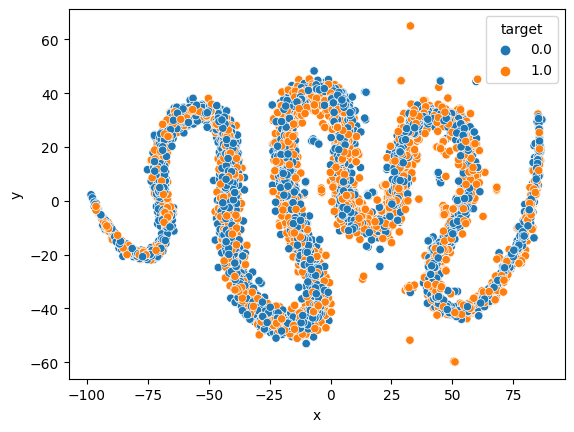

In [ ]:
tsne_plot_df = pd.DataFrame(data=tsne_plot, columns=['x','y','target'])
sns.scatterplot(data=tsne_plot_df, x='x', y='y', hue='target')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, perplexity=50)
X_embedding = tsne.fit_transform(np.array(x))

In [ ]:
tsne_plot = np.hstack((X_embedding, y.reshape(-1,1)))

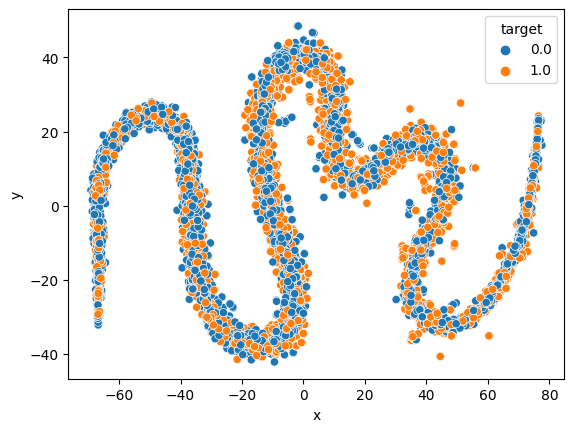

In [ ]:
tsne_plot_df = pd.DataFrame(data=tsne_plot, columns=['x','y','target'])
sns.scatterplot(data=tsne_plot_df, x='x', y='y', hue='target')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, perplexity=100)
X_embedding = tsne.fit_transform(np.array(x))

In [ ]:
tsne_plot = np.hstack((X_embedding, y.reshape(-1,1)))

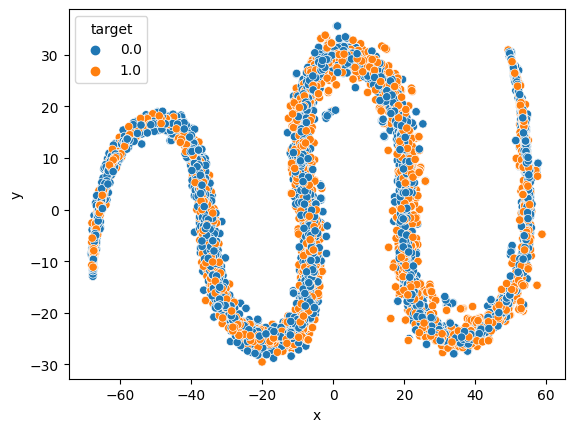

In [ ]:
tsne_plot_df = pd.DataFrame(data=tsne_plot, columns=['x','y','target'])
sns.scatterplot(data=tsne_plot_df, x='x', y='y', hue='target')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, perplexity=150, n_iter=2000)
X_embedding = tsne.fit_transform(np.array(x))

In [ ]:
tsne_plot = np.hstack((X_embedding, y.reshape(-1,1)))

In [ ]:
tsne_plot_df = pd.DataFrame(data=tsne_plot, columns=['x','y','target'])
sns.scatterplot(data=tsne_plot_df, x='x', y='y', hue='target')
plt.show()

In [ ]:
x_train = x[:6001]
y_train = y[:6001]
x_test = x[6001:]
y_test = y[6001:]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
max = 0
k_max=1
for k in range(1, 30):
  neigh = KNeighborsClassifier(n_neighbors=k, weights='distance')
  neigh.fit(x_train, y_train)
  y_pred = neigh.predict(x_test)
  if max<accuracy_score(y_test, y_pred):
    max=accuracy_score(y_test, y_pred)
    k_max=k

In [ ]:
print('Max = ',max,'\n','K = ',k_max)

Max =  0.6378162450066578 
 K =  28


In [ ]:
#################################